In [1]:
import torch
from transformers import RobertaConfig, RobertaForMaskedLM, RobertaTokenizer
import argparse
import json
import os
import pandas as pd
import numpy as np 
from tqdm import tqdm
from scipy import stats
import pickle
import javalang

In [16]:
#!pip install filelock more_itertools
import pandas as pd
import numpy as np 
#import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
np.random.seed(0)
import seaborn as sns
RED = "#e74c3c"
import collections
import pickle

import matplotlib
import numpy as np
import seaborn as sns
import sklearn

from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn import manifold

sns.set_style("darkgrid")
# Pretty colors
BLACK = "k"
GREEN = "#59d98e"
SEA = "#159d82"
BLUE = "#3498db"
PURPLE = "#9b59b6"
GREY = "#95a5a6"
RED = "#e74c3c"
ORANGE = "#f39c12"

In [2]:
def get_cloze_words(filename, tokenizer):
    with open(filename, 'r', encoding='utf-8') as fp:
        words = fp.read().split('\n')
    idx2word = {tokenizer.encoder[w]: w for w in words}
    return idx2word

def read_answers(filename):
    answers = {}
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            line = line.strip()
            answers[line.split('<CODESPLIT>')[0]] = line.split('<CODESPLIT>')[1]
    return answers

def get_CLS_attention(model, tokenizer, codes):
    cls_data = np.zeros((12,12))
    with torch.no_grad():
        for eachCode in tqdm(codes, desc='CLS attention'):
            tokenized_text = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(eachCode))[:512]
            input_ids = torch.tensor([tokenized_text]).to(device)
            output_from_model = model(input_ids)
            
            _attention = output_from_model["attentions"]# attention shape is layers, batchsize, heads, tokenLen, tokenLen
            
            for layer in range(12):
                for head in range(12):
                    cls_data[layer][head] += _attention[layer][0][head][:, 0:1].mean().cpu().detach().numpy() # CLS attention

    CLS_atten = cls_data/len(codes)
    return CLS_atten

def get_SEP_attention(model, tokenizer, codes):
    sep_data = np.zeros((12,12))

    with torch.no_grad():
        for eachCode in tqdm(codes, desc='SEP attention'):
            tokenized_text = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(eachCode))
            # index = inputs.index(tokenizer.mask_token_id)
            inputs_id = torch.tensor([tokenized_text]).to(device)
            output_from_model = model(inputs_id)
            
            _attention = output_from_model["attentions"]# attention shape is layers, batchsize, heads, tokenLen, tokenLen
            
            for layer in range(12):
                for head in range(12):
                    for each_sep_index in torch.where(inputs_id[0]==tokenizer.sep_token_id)[0].cpu().detach().numpy():
                        sep_data[layer][head] += _attention[layer][0][head][:, each_sep_index].mean().cpu().detach().numpy() 

    SEP_atten = sep_data/len(codes)
    return SEP_atten

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Runing on device:', device)
MODEL_CLASSES = {'roberta': (RobertaConfig, RobertaForMaskedLM, RobertaTokenizer)}

config_class, model_class, tokenizer_class = MODEL_CLASSES['roberta']
config = config_class.from_pretrained('roberta-base')
tokenizer = tokenizer_class.from_pretrained('roberta-base')

model = RobertaForMaskedLM.from_pretrained('microsoft/codebert-base-mlm', 
                                        output_attentions=True, output_hidden_states=True)

model.to(device)

Runing on device: cuda:0


RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [5]:
cloze_results = []
cloze_words_file = '../data/cloze-all/cloze_test_words.txt'
file_path = '../data/cloze-all/java/clozeTest.json'

In [7]:
idx2word = get_cloze_words(cloze_words_file, tokenizer)

lines = json.load(open(file_path))

print('Total number of code instances: ', len(lines))

answer_file = '../evaluator/answers/java/answers.txt'
answers = read_answers(answer_file)
answer_list = list(answers.values())

bestSampleWithMaxPairLength = []
bestSampleWithMaxPairLength_LEN =[]

Total number of code instances:  40492


In [80]:
number_of_samples = 2000 # a small set of data for testing
for i in range(len(lines[:number_of_samples])):
    code = ' '.join(lines[i]['pl_tokens'])
    bestStr = "<s> " + code + " </s>"
    bestLen = len(bestStr.split(" "))
    bestSampleWithMaxPairLength.append(bestStr)
    bestSampleWithMaxPairLength_LEN.append(bestLen)
    
lengths=[]
codes=[]
selected_answers = []

for index, code in enumerate(bestSampleWithMaxPairLength):
    l = len(tokenizer.tokenize(code))
    if l<=256:
        lengths.append(l)
        codes.append(code)
        selected_answers.append(answer_list[index])
        
print('Selected number of codes: ', len(codes))
print('Selected number of answers: ', len(selected_answers))

Selected number of codes:  1838
Selected number of answers:  1838


In [81]:
CLS_atten_avg = get_CLS_attention(model, 
                                tokenizer, 
                                codes)

CLS attention: 100%|██████████| 1838/1838 [08:45<00:00,  3.49it/s]


In [82]:
CLS_atten_avg.shape

(12, 12)

In [83]:
SEP_atten_avg = get_SEP_attention(model, 
                                tokenizer, 
                                codes)

SEP attention: 100%|██████████| 1838/1838 [24:07<00:00,  1.27it/s]


In [84]:
avg_attns = {}
avg_attns = {'cls': CLS_atten_avg, 'sep': SEP_atten_avg}

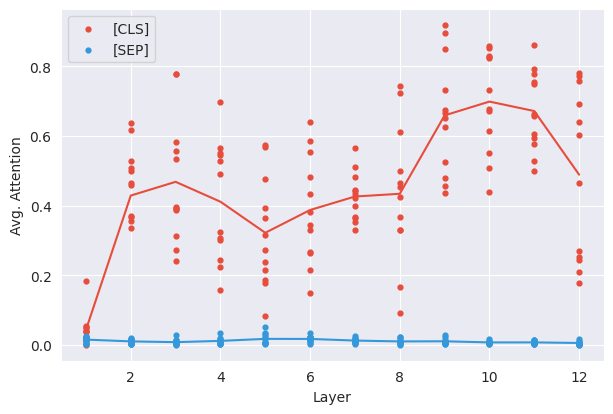

In [85]:
def get_data_points(head_data):
  xs, ys, avgs = [], [], []
  for layer in range(12):
    for head in range(12):
      ys.append(head_data[layer, head])
      xs.append(1 + layer)
    avgs.append(head_data[layer].mean())
  return xs, ys, avgs


## thi is with 2 enfding functions

def add_line(key, ax, color, label, plot_avgs=True):
  xs, ys, avgs = get_data_points(avg_attns[key])
  ax.scatter(xs, ys, s=12, label=label, color=color)
  if plot_avgs:
    ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
  ax.legend(loc="best")
  ax.set_xlabel("Layer")
  ax.set_ylabel("Avg. Attention")


plt.figure(figsize=(7, 21))
ax = plt.subplot(4, 1, 1)
for key, color, label in [ ("cls", RED, "[CLS]"),("sep", BLUE, "[SEP]")]:
  add_line(key, ax, color, label)



## Average attention on Syntactic Types

In [86]:
def get_syntax_types_for_code(code_snippet):
  types = ["[CLS]"]
  code = ["<s>"]
  tree = list(javalang.tokenizer.tokenize(code_snippet))
  
  for i in tree:
    j = str(i)
    j = j.split(" ")
    if j[1] == '"MASK"':
      types.append('[MASK]')
      code.append('<mask>')
    else:
      types.append(j[0].lower())
      code.append(j[1][1:-1])
    
  types.append("[SEP]")
  code.append("</s>")
  return np.array(types), ' '.join(code)

def get_start_end_of_token_when_tokenized(code, types, tokenizer):
  reindexed_types = []
  start = 0
  end = 0
  for index, each_token in enumerate(code.split(" ")):
    tokenized_list = tokenizer.tokenize(each_token)
    for i in range(len(tokenized_list)):
      end += 1
    reindexed_types.append((start, end-1))
    start = end
  return reindexed_types

In [87]:
def getSyntaxAttentionScore(codes, tokenizer, syntaxList):
    # initialize the result dict with empty list for each syntax type
    all_instances = []
    with torch.no_grad():
        for eachCode in tqdm(codes):
            try: 
                Instantce_Result = {}
                for syntaxType in syntaxList:
                    Instantce_Result[syntaxType] = []
                    
                cleancode = eachCode.replace("<s> ", "").replace(" </s>", "").replace('<mask>', 'MASK')
                types, rewrote_code = get_syntax_types_for_code(cleancode)
                # send input to model
                tokenized_text = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(rewrote_code))
                input_ids = torch.tensor([tokenized_text]).to(device)
                output_from_model = model(input_ids)
                # get attention from model
                _attention = output_from_model["attentions"]# attention shape is layers, batchsize, heads, tokenLen, tokenLen
                # get start and end index of each token
                start_end = get_start_end_of_token_when_tokenized(rewrote_code, types, tokenizer)
                
                for syntaxType in syntaxList:
                    attention_weights = [[[] for col in range(12)] for row in range(12)]
                    for layer in range(12):
                        for head in range(12):
                            for each_sep_index in np.where(types==syntaxType)[0]:
                                start_index, end_index = start_end[each_sep_index]
                                interim_value = _attention[layer][0][head][:, start_index:end_index+1].mean().cpu().detach().numpy()
                                if np.isnan(interim_value):
                                    pass
                                else: 
                                    attention_weights[layer][head].append(interim_value)
                                    
                    if np.array(attention_weights).shape[2] != 0:
                        Instantce_Result[syntaxType].append(np.array(attention_weights))
                        
                
            except Exception as e:
                print(e)
                
            all_instances.append(Instantce_Result)
    return all_instances

In [88]:
syntax_list = ['annotation', 'basictype', 'boolean', 
          'decimalinteger', 'identifier', 'keyword',
          'modifier', 'operator', 'separator', 'null',
          'string', 'decimalfloatingpoint']

In [89]:
syntax_attention_weights = getSyntaxAttentionScore(codes, 
                                                    tokenizer, 
                                                    syntax_list)

100%|██████████| 1838/1838 [2:16:33<00:00,  4.46s/it]  


In [96]:

for syntaxType in syntax_list:
    temp = []
    for instance in syntax_attention_weights:
        if len(instance[syntaxType]) != 0:
            temp.append(np.array(instance[syntaxType]).squeeze(0).mean(axis=2))
    temp = np.array(temp)
    temp = temp.reshape(temp.shape[1], temp.shape[2], temp.shape[0])
    avg_temp = temp.max(axis=2)
    avg_attns[syntaxType] = avg_temp
            

In [97]:
syntax_list = ['annotation', 'basictype', 'boolean', 
          'decimalinteger', 'identifier', 'keyword',
          'modifier', 'operator', 'separator', 'null',
          'string', 'decimalfloatingpoint']

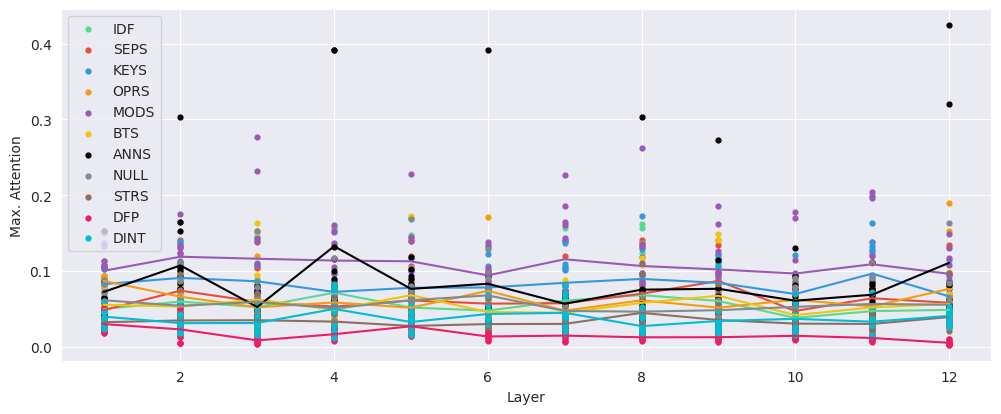

In [98]:
def get_data_points(head_data):
  xs, ys, avgs = [], [], []
  for layer in range(12):
    for head in range(12):
      ys.append(head_data[layer, head])
      xs.append(1 + layer)
    avgs.append(head_data[layer].mean())
  return xs, ys, avgs

def add_line(key, ax, color, label, plot_avgs=True):
  xs, ys, avgs = get_data_points(avg_attns[key])
  ax.scatter(xs, ys, s=12, label=label, color=color)
  if plot_avgs:
    ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
  ax.legend(loc="best")
  ax.set_xlabel("Layer")
  ax.set_ylabel("Max. Attention")
  
  

BLACK = "k"
GREEN = "#59d98e"
SEA = "#159d82"
BLUE = "#3498db"
PURPLE = "#9b59b6"
GREY = "#95a5a6"
RED = "#e74c3c"
ORANGE = "#f39c12"
GRAY = "#7f8c8d"
BROWN = "#8d6e63"
PINK = "#e91e63"
CYAN = "#00bcd4"
YELLOW = "#f1c40f"

plt.figure(figsize=(12, 21))
ax = plt.subplot(4, 1, 1)
for key, color, label in [("identifier", GREEN, "IDF"),("separator", RED, "SEPS"), ("keyword", BLUE, "KEYS"), ("operator", ORANGE, "OPRS"), ("modifier", PURPLE, "MODS"), ("basictype", YELLOW, "BTS"), ("annotation", BLACK, "ANNS"), ("null", GRAY, "NULL"), ("string", BROWN, "STRS"), ("decimalfloatingpoint", PINK, "DFP"), ("decimalinteger", CYAN, "DINT")]:
  add_line(key, ax, color, label, plot_avgs=True)